In [38]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from simulations.analysis.collect_surface_code_simulation_data import aggregate_data

ascending_confidences = {
    "cluster_frac": False,
    "total_boundary_size": False,
    "max_cluster_size": False,
    "max_cluster_llr": False,
    "total_cluster_llr": False,
    "cluster_llr_norm": False,
    "cluster_llr_gap": True,
    "cluster_llr_infty_norm_gap": True,
    "cluster_llr_norm_gap": True,
    "pred_llr": False,
    "detector_density": False,
}

df_agg_dict = {}
for by, ascending_confidence in ascending_confidences.items():
    print(
        f"\nAggregating data for {by} with ascending_confidence={ascending_confidence}..."
    )
    df_agg = aggregate_data(
        by=by,
        d=5,
        p=0.001,
        num_hist_bins=10000,
        ascending_confidence=ascending_confidence,
        verbose=False,
    )
    df_agg_dict[by] = df_agg
    print("=============")


Aggregating data for cluster_frac with ascending_confidence=False...


Range detection:   0%|          | 0/1 [00:00<?, ?it/s]

Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]



Aggregating data for total_boundary_size with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]



Aggregating data for max_cluster_size with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]



Aggregating data for max_cluster_llr with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



Aggregating data for total_cluster_llr with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



Aggregating data for cluster_llr_norm with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]



Aggregating data for cluster_llr_gap with ascending_confidence=True...


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]



Aggregating data for cluster_llr_infty_norm_gap with ascending_confidence=True...


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]



Aggregating data for cluster_llr_norm_gap with ascending_confidence=True...


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]



Aggregating data for pred_llr with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]



Aggregating data for detector_density with ascending_confidence=False...


Aggregation: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

In [34]:
from simulation_data_utils import get_df_ps

df_ps_dict = {}
for by, df_agg in df_agg_dict.items():
    df_ps = get_df_ps(df_agg, ascending_confidence=ascending_confidences[by])
    df_ps_dict[by] = df_ps

In [35]:
def error_band_plot(
    x, y, delta_y, ax=None, color=None, alpha=0.3, y_factor=1, **kwargs
):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y * y_factor, color=color, **kwargs)
    ax.fill_between(
        x,
        (y - delta_y) * y_factor,
        (y + delta_y) * y_factor,
        alpha=alpha,
        color=color,
    )

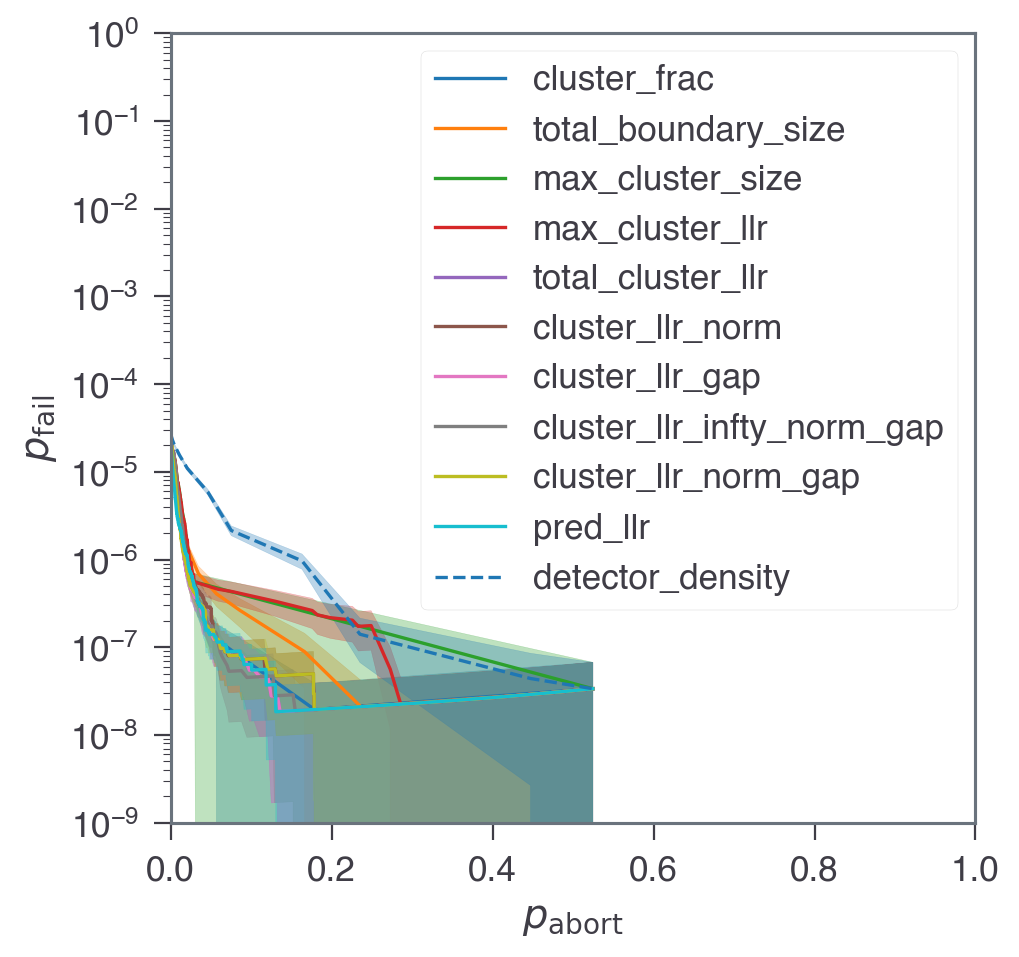

In [36]:
fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 5))

i = 0
data_plots = {}
for by, df_ps in df_ps_dict.items():
    # use_conv = by != "detector_density"
    use_conv = False
    p_abort_col = "p_abort_conv" if use_conv else "p_abort"
    p_fail_col = "p_fail_conv" if use_conv else "p_fail"
    delta_p_fail_col = "delta_p_fail_conv" if use_conv else "delta_p_fail"

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values
    delta_p_fail = df_ps[delta_p_fail_col].values
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=COLORS(i % 10),
        linestyle="-" if i < 10 else "--",
        label=by,
        y_factor=1 / 12,
        ax=ax,
    )
    i += 1

# ax.set_xscale("log")
ax.set_xlim(0, 1)
ax.set_yscale("log")
ax.legend()
ax.set_ylim(1e-9, 1)

ax.set_xlabel(r"$p_\mathrm{abort}$")
ax.set_ylabel(r"$p_\mathrm{fail}$")

fig.tight_layout()

0: cluster_llr_infty_norm_gap (5.44e-07 ± 4.31e-07)
1: total_cluster_llr (6.56e-07 ± 4.84e-07)
2: cluster_llr_gap (6.56e-07 ± 4.84e-07)
3: pred_llr (7.69e-07 ± 5.32e-07)
4: cluster_llr_norm (8.79e-07 ± 5.74e-07)
5: cluster_llr_norm_gap (8.79e-07 ± 5.74e-07)
6: cluster_frac (1.48e-06 ± 7.48e-07)
7: total_boundary_size (3.16e-06 ± 1.13e-06)
8: max_cluster_llr (5.19e-06 ± 1.45e-06)
9: max_cluster_size (6.69e-06 ± 1.61e-06)
10: detector_density (2.57e-05 ± 3.26e-06)


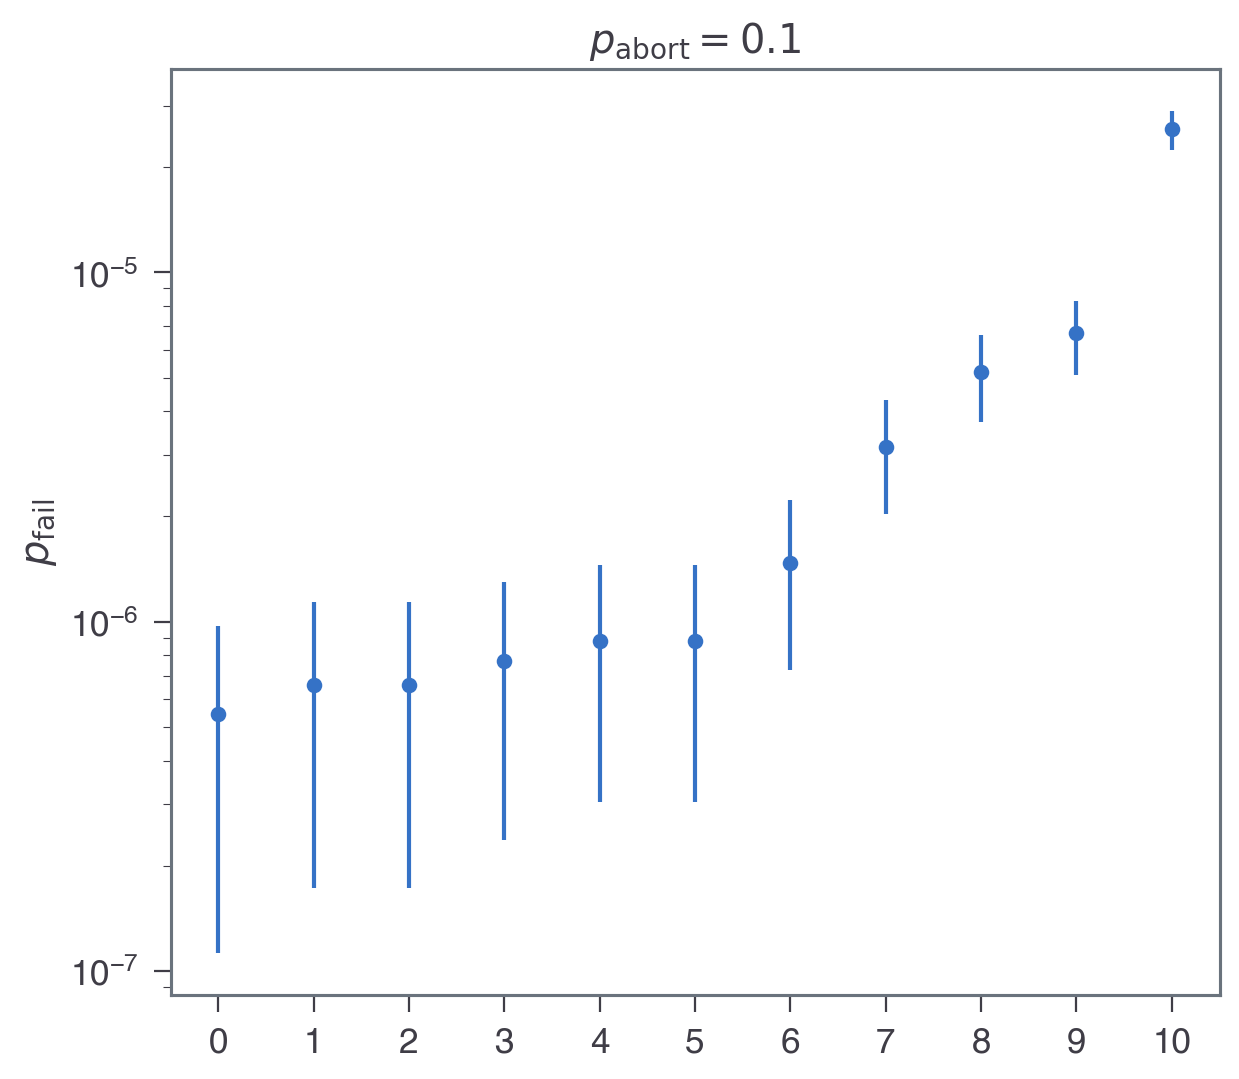

In [37]:
target = 0.1
bys, y_vals, y_errs = [], [], []

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    idx = np.where(p_abort <= target)[0]
    if len(idx):
        sel = idx[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")

x_pos = np.arange(len(bys))

plt.errorbar(
    x_pos,
    y_vals_sorted,
    yerr=y_errs_sorted,
    fmt="o",
    capsize=5,
    lw=1.5,
    markeredgecolor="k",
)
plt.title(rf"$p_\mathrm{{abort}} = {target}$")
plt.xticks(x_pos, x_pos)
plt.ylabel(r"$p_{\mathrm{fail}}$")
plt.yscale("log")
plt.tight_layout()
plt.show()